## やること
1. 抽象クラスMobilityを作成する（済）　
2. Mobilityクラスを継承し、straight,shift,sensor_returnの部分はpassとしておく（済） 
3. 抽象クラスを作成する（済） 
4. Agentクラスの改造（済） 
5. ランドマーク以外に対応できるようコードを改造(済) 
6. Robotクラスのagentクラスの書き足し(self.** -> self.aget.** )（済）
7. Particleクラスへのagentの追加およびMobilityクラスからの継承　（済）
8. Particleクラスのmode,transitionクラスなどの削除 （済）
9. particleクラスへのdrawクラスの追加
10. mclクラスのdrawを、for文処理のみにする
11. EstimationAgentクラスをAgentXクラス対応にする（済）

In [112]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from scipy.stats import expon, norm, uniform
from scipy.stats import multivariate_normal
from enum import Enum
import random 
import copy

In [113]:
class World:
    def __init__(self, time_span, time_interval, debug=True):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 

        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-250,250)                  
        ax.set_ylim(-250,250)
        #ax.set_xlim(-5,5)
        #ax.set_ylim(-5,5)
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-245.4, 220, time_str, fontsize=10))
        #elems.append(ax.text(-4.4, 4.5, time_str,fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    


In [114]:
#抽象クラスを作成する
class rob:
    def __init__(self,pose,agent):
        self.pose = pose
        self.agent = agent
    
    def draw(self,ax, elems):
        pass
    
    def state_transition(self,nu,omega,time,pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
        
    def transition(self, nu,omega, time,obs):
        if self.agent.mode == Mode.STATE_TRANSITION:
            return self.state_transition(nu,omega,time,self.pose)
        elif self.agent.mode == Mode.STRAIGHT_TRANSITION:
            return self.straight_transition(nu,omega, time, obs)
        elif self.agent.mode == Mode.SHIFT_TRANSITION:
            return self.shift_transition(nu,omega,time, obs)
        else:
            return self.state_transition(nu,omega,time, self.pose)
        
    def sensor_return(self,obs):
        if obs:         
            if np.abs(obs[0][0][1]) > self.angle /180 * math.pi :
                self.obs_stuck = np.abs(obs[0][0][1]) - self.angle / 180 * math.pi
                self.obs_sign = np.sign(obs[0][0][1])
                return  self.obs_sign * self.angle / 180 * math.pi
            else:
                return obs[0][0][1]

        if self.obs_stuck > self.angle / 180 * math.pi:
            self.obs_stuck = self.obs_stuck - self.angle / 180 * math.pi
            return self.obs_sign *  self.angle / 180 * math.pi
        else:
            self.a = self.obs_stuck
            self.b = self.obs_sign
            self.obs_stuck = 0
            self.obs_sign = 0
            return self.a *self.b / 180 * math.pi
                            
    def straight_transition(self,nu,omega,time,obs):
        if obs:  
            if obs[0][0][0] < self.agent.distance_minimum:
                self.agent.decelerate_nu()
                self.agent.keep_straight_change()
                

        t0 = self.pose[2]        
            
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu* math.cos(t0)*time, 
                             nu *math.sin(t0)*time,
                             omega*time  + self.sensor_return(obs)] )
        else:
            return self.pose + np.array( [nu  / omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                             nu  / omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                             omega*time + self.sensor_return(obs) ] )
        
                    
    def shift_transition(self, nu, omega, time, obs):
        if obs:
            if obs[0][0][0] < self.agent.distance_minimum:
                self.agent.decelerate_nu
                self.agent.keep_shift_change()
            
        t0 = self.pose[2]
        
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu *math.cos(t0)*time+2.0, 
                                 nu *math.sin(t0)*time,
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time+2.0)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) * math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) 
        else:
            return self.pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0, 
                                 nu  /omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0)**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 )) * math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0)))**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 ))

In [115]:
#robクラスを継承し、straight,shift,sensor_returnの部分はpassとしておく
class IdealRobot(rob):   
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        super().__init__(pose,agent)
        self.pose = pose
        self.r = 10  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.id = None
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):         ### call_agent_draw
        x, y, theta = self.pose  
        xn = x + self.r * math.cos(theta)  
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems.append(ax.text(self.pose[0]-20, self.pose[1]-20, "child AUV "+ str(self.id), fontsize=8))         
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1: 
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)

    def one_step(self, time_interval):
        if not self.agent: return        
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)   


In [116]:
# In[4]:


class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega

In [117]:
#Agentクラスの改造（済）
class AgentX:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
        self.mode = Mode.STATE_TRANSITION
        
        self.accelerate_rate = 5   
        self.shift_switch = False
        self.keep_straight = False
        self.keep_shift = False
        
        self.distance_maximum = 320
        self.distance_minimum = 30
        
    def decision(self, observation=None):
        if observation:
            self.mode = self.mode_change(observation)
        return self.nu, self.omega
    
    def shift_switch_change(self):
        self.shift_switch = not self.shift_switch
    
    def keep_straight_change(self):
        self.keep_straight = not self.keep_straight
    
    def keep_shift_change(self):
        self.keep_shift = not self.keep_shift
        
    def accelerate_nu(self):
        self.nu = self.nu * self.accelerate_rate
    
    def decelerate_nu(self):
        self.nu = self.nu / self.accelerate_rate
        
    def mode_change(self,obs):
        if ((obs[0][0][0] > self.distance_maximum) and(self.shift_switch == False)) or (self.keep_straight == True) :
            if (self.keep_straight == False) :
                self.accelerate_nu()
                self.keep_straight_change()
            return Mode.STRAIGHT_TRANSITION
        elif ((obs[0][0][0] > self.distance_maximum) and (self.shift_switch == True)) or (self.keep_shift == True):
            if (self.keep_shift == False):
                self.accelerate_nu()
                self.nu = self.nu * self.accelerate_rate
            return Mode.SHIFT_TRANSITION
        else:
            return Mode.STATE_TRANSITION

In [118]:
# In[5]:
class Landmark:
    def __init__(self, pos , agent = None):
        self.pos = pos
        self.agent = agent
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=30, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0]-20, self.pos[1]-20, "parent AUV" + str(self.id), fontsize=8))
        
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return        
        nu, omega = self.agent.decision() #引数追加
        self.pos = self.state_transition(nu, omega, time_interval, self.pos)

In [119]:
# In[6]:
#ランドマーク以外に対応できるようコードを改造（済）
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.objects = []
        
    def append_object(self, ob):       # ランドマークを追加
        ob.id = len(self.objects)           # 追加するランドマークにIDを与える
        self.objects.append(ob)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for ob in self.objects: ob.draw(ax, elems)

    def one_step(self,time_interval):
        for ob in self.objects: ob.one_step(time_interval)
                        

In [120]:
class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 300), direction_range=(-math.pi, math.pi)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]                 and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.objects:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos[0:2]- cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

In [121]:
class Mode(Enum):
    STATE_TRANSITION = 1
    STRAIGHT_TRANSITION = 2
    SHIFT_TRANSITION = 3

In [122]:
# In[3]:

class Camera(IdealCamera): ###noisesim_occlusion### 
    def __init__(self, env_map,
                 distance_range=(0.5, 500),
                 direction_range=(-math.pi, math.pi),
                 distance_noise_rate=0.05, direction_noise=math.pi/180,
                 distance_bias_rate_stddev=0.05, direction_bias_stddev=math.pi/180,
                 phantom_prob=0.0, phantom_range_x=(-5.0,5.0), phantom_range_y=(-5.0,5.0),
                 oversight_prob=0.1, occlusion_prob=0.0): #occlusion_prob追加
        super().__init__(env_map, distance_range, direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise  
        self.distance_bias_rate_std = norm.rvs(scale=distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale=direction_bias_stddev) 
        
        rx, ry = phantom_range_x, phantom_range_y
        self.phantom_dist = uniform(loc=(rx[0], ry[0]), scale=(rx[1]-rx[0], ry[1]-ry[0]))
        self.phantom_prob = phantom_prob
        
        self.oversight_prob = oversight_prob
        self.occlusion_prob = occlusion_prob #追加
        
    def noise(self, relpos):  
        ell = norm.rvs(loc=relpos[0], scale=relpos[0]*self.distance_noise_rate)
        phi = norm.rvs(loc=relpos[1], scale=self.direction_noise)
        return np.array([ell, phi]).T
    
    def bias(self, relpos): 
        return relpos + np.array([relpos[0]*self.distance_bias_rate_std,
                                  self.direction_bias]).T
    
    def phantom(self, cam_pose, relpos):
        if uniform.rvs() < self.phantom_prob:
            pos = np.array(self.phantom_dist.rvs()).T
            return self.observation_function(cam_pose, pos)
        else:
            return relpos
        
    def oversight(self, relpos):
        if uniform.rvs() < self.oversight_prob:
            return None
        else:
            return relpos
        
    def occlusion(self, relpos): #追加
        if uniform.rvs() < self.occlusion_prob:
            ell = relpos[0] + uniform.rvs()*(self.distance_range[1] - relpos[0])
            return np.array([ell, relpos[1]]).T   
        else:
            return relpos
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.objects:
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z) 
            z = self.occlusion(z) #追加
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)  
                observed.append((z, lm.id))
                
            
        self.lastdata = observed 
        return observed


In [123]:
#robot.** -> robot.agent.**（済）
class Robot(IdealRobot):
        
    def __init__(self, pose, agent=None, sensor=None, color="black",                            noise_per_meter=5, noise_std=math.pi/180, bias_rate_stds=(0.1,0.1),                            expected_stuck_time=1e100, expected_escape_time = 1e-100,                           expected_kidnap_time=1e100, kidnap_range_x = (-5.0,5.0), kidnap_range_y = (-5.0,5.0)): #追加
        super().__init__(pose, agent, sensor, color)
        #noise に必要な変数
        #大域でグラフを生成しないと関数の呼び出しごとに関数を生成することになる
        #出てくる値がランダムじゃなくなる
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        
        #biasに必要な関数
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1]) 
        
        #stuckに必要な関数
        self.stuck_pdf = expon(scale=expected_stuck_time) 
        self.escape_pdf = expon(scale=expected_escape_time)
        self.is_stuck = False
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        
        #kidnapに必要な関数
        self.kidnap_pdf = expon(scale=expected_kidnap_time) 
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx, ry = kidnap_range_x, kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0], ry[0], 0.0), scale=(rx[1]-rx[0], ry[1]-ry[0], 2*math.pi ))
        
        #one_stepに必要な関数
        self.is_first = True
        
        self.const_time = 1.0
        self.sensor_time = self.const_time
        
        self.sensor_stuck = []
        
        self.obs_stuck = 0
        self.obs_sign = 0
        
        self.angle = 3
        
        self.a = 0
        self.b = 0

        self.count = 0
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
        
    def bias(self, nu, omega): 
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega
    
    def stuck(self, nu, omega, time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:            
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True

        return nu*(not self.is_stuck), omega*(not self.is_stuck)
         
    
    def kidnap(self, pose, time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
        
    def sensor_append(self, mode, obs):
        if mode == True:
            if obs:
                self.sensor_stuck.append(obs)
    
    
    def sensor_return(self,obs):
        if obs:         
            if np.abs(obs[0][0][1]) > self.angle /180 * math.pi :
                self.obs_stuck = np.abs(obs[0][0][1]) - self.angle / 180 * math.pi
                self.obs_sign = np.sign(obs[0][0][1])
                return  self.obs_sign * self.angle / 180 * math.pi
            else:
                return obs[0][0][1]

        if self.obs_stuck > self.angle / 180 * math.pi:
            self.obs_stuck = self.obs_stuck - self.angle / 180 * math.pi
            return self.obs_sign *  self.angle / 180 * math.pi
        else:
            self.a = self.obs_stuck
            self.b = self.obs_sign
            self.obs_stuck = 0
            self.obs_sign = 0
            return self.a *self.b / 180 * math.pi
            
        
                
    def straight_transition(self,nu,omega,time,obs):
        if obs:  
            if obs[0][0][0] < self.agent.distance_minimum:
                self.agent.decelerate_nu()
                self.agent.keep_straight_change()
                

        t0 = self.pose[2]        
            
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu* math.cos(t0)*time, 
                             nu *math.sin(t0)*time,
                             omega*time  + self.sensor_return(obs)] )
        else:
            return self.pose + np.array( [nu  / omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                             nu  / omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                             omega*time + self.sensor_return(obs) ] )
        
                    
    def shift_transition(self, nu, omega, time, obs):
        if obs:
            if obs[0][0][0] < self.agent.distance_minimum:
                self.agent.decelerate_nu
                self.agent.keep_shift_change()
            
        t0 = self.pose[2]
        
        if math.fabs(omega) < 1e-10:
            return self.pose + np.array( [nu *math.cos(t0)*time+2.0, 
                                 nu *math.sin(t0)*time,
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time+2.0)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) * math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) 
        else:
            return self.pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0, 
                                 nu  /omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                 omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0)**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 )) * math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0)))**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 ))
         
        
    
    def transition(self, nu,omega, time,obs):
        print(self.agent.mode)
        if self.agent.mode == Mode.STATE_TRANSITION:
            return self.state_transition(nu,omega,time,self.pose)
        elif self.agent.mode == Mode.STRAIGHT_TRANSITION:
            return self.straight_transition(nu,omega, time, obs)
        elif self.agent.mode == Mode.SHIFT_TRANSITION:
            return self.shift_transition(nu,omega,time, obs)
        else:
            return self.state_transition(nu,omega,time, self.pose)
    
    
    def sensor_count(self, time_interval):
        if(self.sensor_time >= 0.1) and (self.is_first == False):
            self.sensor_time -= time_interval
            return None
        elif self.is_first == True:
            self.is_first = False
            return self.sensor.data(self.pose) if self.sensor else None
        else:
            self.sensor_time = self.const_time
            return self.sensor.data(self.pose) if self.sensor else None
        
    def one_step(self,time_interval):
        if not self.agent: return
        
        obs = self.sensor_count(time_interval)
            
        self.sensor_append(True,obs)
           
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu,omega)
        nu, omega = self.stuck(nu,omega,time_interval)
        
        self.pose = self.transition(nu,omega,time_interval,obs)
        self.pose = self.noise(self.pose, nu,omega, time_interval)
        self.pose = self.kidnap(self.pose, time_interval)
        self.count = self.count + 1


In [140]:
#Particleクラスへのagentの追加およびMobilityクラスからの継承
#mode,transitionクラスなどの削除
#particleクラスへのdrawクラスの追加
class Particle(rob): 
    def __init__(self,init_pose,agent, weight):
        super().__init__(init_pose, agent)
        self.weight = weight
        
#         self.mode = Mode.STATE_TRANSITION
        
#         self.distance_maximum = 340
#         self.distance_minimum = 30
        
#         self.shift_switch = False
#         self.keep_straight = False
#         self.keep_shift = False
        
        self.obs = []
        
#         self.a = 0
#         self.b = 0
        
#         self.obs_stuck = 0
#         self.obs_sign =0
        
#         self.angle = 3
#         self.accelerate_rate = 5
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): 
        ns = noise_rate_pdf.rvs()
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        if self.obs:
            self.mode = self.agent.mode_change(self.obs)
        self.pose = self.transition(pnu, pomega, time, self.obs)
        
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):  #変更_
        self.obs = observation
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.objects[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)
        
        
#     def mode_change(self,mode,obs):
#         if ((obs[0][0][0] > self.distance_maximum) and(self.shift_switch == False)) or (self.keep_straight == True) :
#             return Mode.STRAIGHT_TRANSITION
#         elif ((obs[0][0][0] > self.distance_maximum) and (self.shift_switch == True)) or (self.keep_shift == True):
#             return Mode.SHIFT_TRANSITION
#         else:
#             return Mode.STATE_TRANSITION      
    
#     def transition(self,mode, nu,omega, time,obs):
#         if mode == Mode.STATE_TRANSITION:
#             return self.state_transition(nu,omega,time)
#         elif mode == Mode.STRAIGHT_TRANSITION:
#             return self.straight_transition(nu,omega, time, obs)
#         elif mode == Mode.SHIFT_TRANSITION:
#             return self.shift_transition(nu,omega,time, obs)
#         else:
#             return self.state_transition(nu,omega,time)
        
        
#     def sensor_return(self,obs):
#         if obs:         
#             if np.abs(obs[0][0][1]) > self.angle /180 * math.pi :
#                 self.obs_stuck = np.abs(obs[0][0][1]) - self.angle / 180 * math.pi
#                 self.obs_sign = np.sign(obs[0][0][1])
#                 return  self.obs_sign * self.angle / 180 * math.pi
#             else:
#                 return obs[0][0][1]

#         if self.obs_stuck > self.angle / 180 * math.pi:
#             self.obs_stuck = self.obs_stuck - self.angle / 180 * math.pi
#             return self.obs_sign *  self.angle / 180 * math.pi
#         else:
#             self.a = self.obs_stuck
#             self.b = self.obs_sign
#             self.obs_stuck = 0
#             self.obs_sign = 0
#             return self.a *self.b / 180 * math.pi
        
#     def state_transition(self, nu, omega, time):
#         t0 = self.pose[2]
#         if math.fabs(omega) < 1e-10:
#             return self.pose + np.array( [nu*math.cos(t0), 
#                                      nu*math.sin(t0),
#                                      omega ] ) * time
#         else:
#             return self.pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
#                                      nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
#                                      omega*time ] )

#     def straight_transition(self,nu,omega,time,obs):
#         if obs: 
#             if obs[0][0][0]< self.distance_minimum:
#                 self.keep_straight = False
#             else:
#                 self.keep_straight = True
            
#         t0 = self.pose[2]        
            
#         if math.fabs(omega) < 1e-10:
#             return self.pose + np.array( [nu* self.accelerate_rate * math.cos(t0)*time, 
#                              nu* self.accelerate_rate *math.sin(t0)*time,
#                              omega*time  + self.sensor_return(obs)] )
#         else:
#             return self.pose + np.array( [nu * self.accelerate_rate / omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
#                              nu * self.accelerate_rate / omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
#                              omega*time + self.sensor_return(obs) ] )
                    
#     def shift_transition(self, nu, omega, time, obs):
#         if obs:
#             if obs[0][0][0] < self.distance_minimum:
#                 self.keep_shift = False
#             else:
#                 self.keep_shift = True
            
#         t0 = self.pose[2]
        
#         if math.fabs(omega) < 1e-10:
#             return self.pose + np.array( [nu * self.accelerate_rate *math.cos(t0)*time+2.0, 
#                                  nu * self.accelerate_rate *math.sin(t0)*time,
#                                  omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time+2.0)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) * math.sqrt((nu * self.accelerate_rate *math.cos(t0)*time)**2 +(nu * self.accelerate_rate *math.sin(t0)*time)**2) 
#         else:
#             return self.pose + np.array( [nu * self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0, 
#                                  nu * self.accelerate_rate /omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
#                                  omega*time+self.sensor_return(obs) ] )/ math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0))+2.0)**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 )) * math.sqrt((nu* self.accelerate_rate/omega*(math.sin(t0 + omega*time) - math.sin(t0)))**2 + (nu* self.accelerate_rate/omega*(-math.cos(t0 + omega*time) + math.cos(t0))**2 ))


In [129]:
#mclクラスのdrawを、for文処理のみにする
class Mcl:    ###mlparticle（12〜18行目）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},                  distance_dev_rate=0.14, direction_dev=0.05):
        self.particles = [Particle(init_pose,AgentX(0,0), 1.0/num) for i in range(num)]
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        self.ml = self.particles[0] #追加
        self.pose = self.ml.pose #追加（互換性のため）
        
    def set_ml(self): #追加
        #パーティクルの中で重みが大きいパーティクルの番号を返す
        i = np.argmax([p.weight for p in self.particles])
        self.ml = self.particles[i]
        self.pose = self.ml.pose
        
    def motion_update(self, nu, omega, time): 
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
            
    def observation_update(self, observation): 
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
        self.set_ml() #リサンプリング前に実行
        self.resampling() 
            
    def resampling(self): ###systematicsampling
        ws = np.cumsum([e.weight for e in self.particles]) #重みを累積して足していく（最後の要素が重みの合計になる）
        if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws]  #重みの合計が0のときの処理
            
        step = ws[-1]/len(self.particles)   #正規化されていない場合はステップが「重みの合計値/N」になる
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        ps = []            #抽出するパーティクルのリスト
        
        while(len(ps) < len(self.particles)):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])  #もしかしたらcur_posがはみ出るかもしれませんが例外処理は割愛で
                r += step
            else:
                cur_pos += 1

        self.particles = [copy.deepcopy(e) for e in ps]                   #以下の処理は前の実装と同じ
        for p in self.particles: p.weight = 1.0/len(self.particles)
        
    def draw(self, ax, elems):  
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2])*p.weight*len(self.particles) * 800 for p in self.particles] #重みを要素に反映
        vys = [math.sin(p.pose[2])*p.weight*len(self.particles) * 800 for p in self.particles]  #重みを要素に反映
        elems.append(ax.quiver(xs, ys, vxs, vys,                                angles='xy', scale_units='xy',color="orange", alpha=0.5)) #変更

In [126]:
#EstimationAgentクラスをAgentXクラス対応にする(済)
class EstimationAgent(AgentX): 
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        if observation:
            self.estimator.observation_update(observation)
            self.mode = self.mode_change(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pose #以下追加
        s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        elems.append(ax.text(0, 220,s, fontsize=8))

<IPython.core.display.Javascript object>


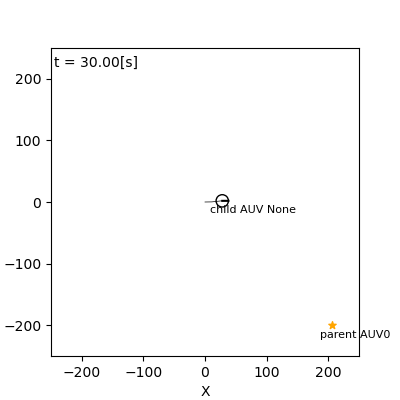

In [127]:
world = World(30,0.1, debug=False)

m = Map()
circling = AgentX(1,10.0/180*math.pi)
straight = Agent(0.2, 0.0)
straight1 = AgentX(1,0.0)

r = Robot(np.array([0,0,0]).T,sensor = Camera(m), agent=straight1)
world.append(r)
m.append_object(Landmark(np.array([200,-200,0]).T, agent = straight))
world.append(m)          

world.draw()

<IPython.core.display.Javascript object>


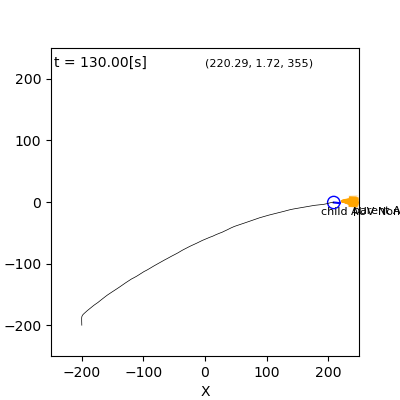

In [144]:
time_interval = 0.1
world = World(130, time_interval, debug = False)

m = Map()
straight = Agent(2.0,0)
initial_pose_1 = np.array([0,0,0]).T

m.append_object(Landmark(initial_pose_1, agent = straight))
world.append(m)    

initial_pose_2 = np.array([-200,-200,math.pi / 2 ]).T
estimator2 = Mcl(m,initial_pose_2,100)
b = EstimationAgent(time_interval, 1,0,estimator2) 
r_2 = Robot(initial_pose_2 , sensor = Camera(m),agent = b, color = "blue")
world.append(r_2)

world.draw()